This codes takes CIM Program data, CIM Assesssments Data, and Admissions data and returns effectiveness measure for TOC, COPD, and CHF Care Management Programs.

Instructions for how to update.
1. Run 3 SQL queries in zip folder - "progs", "assessments", and "admits", they are stored in github.com/tysonjens
2. Run queries and save locally to your computer. Delimit query results with "|".
3. Update "read_csv" commands (below) to corresopnd to your local paths
4. Run the script and note outputs for the several analyses


In [192]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from pandas.tseries.offsets import Day
from sklearn import linear_model
from sklearn.preprocessing import Imputer
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import statsmodels.formula.api as sm
# import warnings; warnings.simplefilter('ignore')
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_rows', 500)
%matplotlib inline

## Functions

Before importing and analyzing the data, we define several functions that help link and create features using the three data files.

In [193]:
## function that finds the most recent discharge before a program begins
def find_index_discharge_date(programs, admissions):
    admissions = admissions.sort_values(by='discharge_date', ascending=False)
    index_dates = np.empty(programs.shape[0])
    index_dates[:] = np.nan
    index_dates = list(index_dates)
    for index, row in programs.iterrows():
        admit_pat = admissions[admissions['EMPI']==row['EMPI']]
        for index2, row2 in admit_pat.iterrows():
            if row2['discharge_date'] < row['prog_create_date']:
                index_dates[index] = row2['discharge_date']
                break
            else:
                continue
    return index_dates

In [194]:
## function that finds the first assessment completed after discharge and records the date
def find_first_assess(programs, assessments):
    assessments = assessments.sort_values(by='ASES_DT', ascending=True)
    first_assess_dates = np.empty(programs.shape[0])
    first_assess_dates[:] = np.nan
    first_assess_dates = list(first_assess_dates)
    first_assess_name = np.empty(programs.shape[0])
    first_assess_name[:] = np.nan
    first_assess_name = list(first_assess_name)
    for index, row in programs.iterrows():
        assess_pat = assessments[assessments['EMPI']==row['EMPI']]
        for index2, row2 in assess_pat.iterrows():
            if row2['ASES_DT'] > row['index_date']:
                first_assess_dates[index] = row2['ASES_DT']
                first_assess_name[index] = row2['ASES_NM']
                break
            else:
                continue
    return first_assess_dates, first_assess_name

In [195]:
## function that finds a LACE score that occurred within 40 days (prior) to program start date
def find_lace_prior_to_enroll(programs, lace, window_size=40):
    lace = lace.sort_values(by='ASES_DT', ascending=False)
    lace_scores = np.empty(programs.shape[0])
    lace_scores[:] = np.nan
    lace_scores = list(lace_scores)
    for index, row in programs.iterrows():
        lace_pat = lace[lace['EMPI']==row['EMPI']]
        for index2, row2 in lace_pat.iterrows():
            if (row2['ASES_DT'] < row['prog_create_date']) & (row2['ASES_DT'] > (row['prog_create_date']-timedelta(days=window_size))):
                lace_scores[index] = row2['ASES_SCOR']
                break
            else:
                continue
    return lace_scores

In [196]:
## function that finds the LACE dates that occurred within 40 days (prior) to program start date
def find_lace_dt_prior_to_enroll(programs, lace, window_size=40):
    lace = lace.sort_values(by='ASES_DT', ascending=False)
    lace_dates = np.empty(programs.shape[0])
    lace_dates[:] = np.nan
    lace_dates = list(lace_dates)
    for index, row in programs.iterrows():
        lace_pat = lace[lace['EMPI']==row['EMPI']]
        for index2, row2 in lace_pat.iterrows():
            if (row2['ASES_DT'] < row['prog_create_date']) & (row2['ASES_DT'] > (row['prog_create_date']-timedelta(days=window_size))):
                lace_dates[index] = row2['ASES_DT']
                break
            else:
                continue
    return lace_dates

In [197]:
## Function that counts assessments that occur during a program.
def find_assessments_during_program(programs, assess):
    assess_cnt = np.zeros(programs.shape[0])
    assess_cnt = list(assess_cnt)
    for index, row in programs.iterrows():
        assess_pat = assess[(assess['EMPI']==row['EMPI']) &
                             (assess['ASES_DT'] > (row['prog_create_date']-timedelta(days=1))) &
                             (assess['ASES_DT'] < (row['prog_end_date']+timedelta(days=1)))]
        assess_cnt[index] = assess_pat.shape[0]
    return assess_cnt

In [198]:
## Function that counts assessments in the 30-day window following a discharge (starts at "index date")
def find_assessments_during_TOC(programs, assess):
    assess_cnt_toc = np.zeros(programs.shape[0])
    assess_cnt_toc = list(assess_cnt_toc)
    for index, row in programs.iterrows():
        assess_pat = assess[(assess['EMPI']==row['EMPI']) &
                             (assess['ASES_DT'] > (row['index_date'])) &
                             (assess['ASES_DT'] < (row['index_date']+timedelta(days=31)))]
        assess_cnt_toc[index] = assess_pat.shape[0]
    return assess_cnt_toc

In [199]:
## Function that counts assessments during the first 90 days of a program. Used in the this code for DM programs.
def find_assessments_during_program_dm(programs, assess):
    assess_cnt = np.zeros(programs.shape[0])
    assess_cnt = list(assess_cnt)
    for index, row in programs.iterrows():
        assess_pat = assess[(assess['EMPI']==row['EMPI']) &
                             (assess['ASES_DT'] > (row['prog_create_date']-timedelta(days=1))) &
                             (assess['ASES_DT'] < (row['prog_create_date']+timedelta(days=91)))]
        assess_cnt[index] = assess_pat.shape[0]
    return assess_cnt

In [200]:
## Convenience function that converts a list of counts into a binary "flag"
def list_of_counts_to_flag(ases):
    ases_yn = []
    for num in ases:
        if num>0:
            ases_yn.append(1)
        else:
            ases_yn.append(0)
    return ases_yn

In [201]:
## Function that counts the number of admits and length of stay in a window AFTER a program begins. For disease management
def get_adm_after(programs, admissions, window_size=90):
    admits_in_window = list(np.zeros(programs.shape[0]))
    los_in_window = list(np.zeros(programs.shape[0]))
    for index, row in programs.iterrows():
        admit_pat = admissions[admissions['EMPI']==row['EMPI']]
        count = 0
        los = 0
        for index2, row2 in admit_pat.iterrows():
            if (row2['admit_date'] < (row['prog_create_date']+timedelta(days=window_size))) & (row2['admit_date'] > row['prog_create_date']):
                count+=1
                los += row2['length_of_stay']
        admits_in_window[index] = count
        los_in_window[index] = los
    return admits_in_window, los_in_window

In [202]:
## Function that counts the number of admits and length of stay in a window BEFORE a program begins. For disease management.
def get_adm_before(programs, admissions, window_size=90):
    admits_in_window = list(np.zeros(programs.shape[0]))
    los_in_window = list(np.zeros(programs.shape[0]))
    for index, row in programs.iterrows():
        admit_pat = admissions[admissions['EMPI']==row['EMPI']]
        count = 0
        los = 0
        for index2, row2 in admit_pat.iterrows():
            if (row2['admit_date'] > (row['prog_create_date']-timedelta(days=window_size))) & (row2['admit_date'] > (row['prog_create_date']-timedelta(days=10))):
                count+=1
                los += row2['length_of_stay']
        admits_in_window[index] = count
        los_in_window[index] = los
    return admits_in_window, los_in_window

In [203]:
## Function that counts the number of admits in a window AFTER the index readmission. For TOC.
def get_adm_after_index_discharge(programs, admissions, window_size=30):
    admits_in_window = list(np.zeros(programs.shape[0]))
    for index, row in programs.iterrows():
        admit_pat = admissions[admissions['EMPI']==row['EMPI']]
        count = 0
        for index2, row2 in admit_pat.iterrows():
            if (row2['admit_date'] < (row['index_date']+timedelta(days=window_size))) & (row2['admit_date'] > row['index_date']):
                count+=1
        admits_in_window[index] = count
    return admits_in_window

In [204]:
## Convenience function that converts a column of integer counts into a binary "flag"
def adms_to_one_zero(progs, field):
    adm_yn = []
    for index, row in progs.iterrows():
        if row[field]>0:
            adm_yn.append(1)
        else:
            adm_yn.append(0)
    return adm_yn

In [205]:
## Plots "Receiver Operating Characteristic" Curve to evaluate Classification Model Performance.  
## Takes "TPR" or true positive rates, and "FPR" for false positive rates for various thresholds and returns plot of curve
def plotroc(TPR, FPR):
    roc_auc = auc(TPR, FPR)
    plt.figure()
    lw = 2
    plt.plot(TPR, FPR, color='darkorange',
             lw=lw, label="ROC curve area = {0:0.4f}".format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [206]:
## Function that uses "bootstraping" to find the distribution of likely values for model coefficients.
def bootstrap_ci_coefficients(X_train, y_train, num_bootstraps, class_weight={0: 1, 1: 1}):
    bootstrap_estimates = []
    for i in np.arange(num_bootstraps):
        sample_index = np.random.choice(range(0, len(y_train)), len(y_train))
        X_samples = X_train[sample_index]
        y_samples = y_train[sample_index]
        lm = linear_model.LogisticRegression(class_weight=class_weight, penalty='l1', C=100000000)
        lm.fit(X_samples, y_samples)
        bootstrap_estimates.append(lm.coef_[0])
    bootstrap_estimates = np.asarray(bootstrap_estimates)
    return bootstrap_estimates

In [207]:
## For COPD, find wehther or not there was a 90 day admission
def tag_copd_admissions(dm_progs, rel_admits):
    dm_admit_yn = list(np.zeros(rel_admits.shape[0]))
    dm_optin_yn = np.empty(rel_admits.shape[0])
    dm_optin_yn[:] = np.nan
    dm_optin_yn = list(dm_optin_yn)
    dm_week = np.empty(rel_admits.shape[0])
    dm_week[:] = np.nan
    dm_week = list(dm_optin_yn)
    for index, row in dm_progs.iterrows():
        for index2, row2 in rel_admits.iterrows():
            if (row2['EMPI']==row['EMPI']) & (row2['admit_date'] > (row['prog_create_date']-timedelta(days=90))) & (row2['admit_date'] < (row['prog_create_date']+timedelta(days=90))):
                dm_admit_yn[index] = 1
                dm_optin_yn[index] = (row['copd_ases']>0)
                dm_week[index] = int(((row2['admit_date']-row['prog_create_date'])/timedelta(days=1))/7)
    return dm_admit_yn, dm_optin_yn, dm_week

In [208]:
## For CHF, find wehther or not there was a 90 day admission
def tag_chf_admissions(dm_progs, rel_admits):
    dm_admit_yn = list(np.zeros(rel_admits.shape[0]))
    dm_optin_yn = np.empty(rel_admits.shape[0])
    dm_optin_yn[:] = np.nan
    dm_optin_yn = list(dm_optin_yn)
    dm_week = np.empty(rel_admits.shape[0])
    dm_week[:] = np.nan
    dm_week = list(dm_optin_yn)
    for index, row in dm_progs.iterrows():
        for index2, row2 in rel_admits.iterrows():
            if (row2['EMPI']==row['EMPI']) & (row2['admit_date'] > (row['prog_create_date']-timedelta(days=90))) & (row2['admit_date'] < (row['prog_create_date']+timedelta(days=90))):
                dm_admit_yn[index] = 1
                dm_optin_yn[index] = (row['chf_ases']>0)
                dm_week[index] = int(((row2['admit_date']-row['prog_create_date'])/timedelta(days=1))/7)
    return dm_admit_yn, dm_optin_yn, dm_week

In [209]:
## Convinience function that converts integers less that 30 to "1", else "0" to identify patient who received med_rec
def medrec_yn(medrec):
    medrec_yn = []
    medrec = list(medrec)
    for i in medrec:
        if i < 30:
            medrec_yn.append(1)
        else:
            medrec_yn.append(0)
    return medrec_yn
    

## Read in Data

In [210]:
## READ In Programs, Admissions, and Assessments data
progs = pd.read_csv('../data/20190305progs.csv', sep='|', low_memory=False)

In [211]:
## Remember to strip out SQL notifications from SQL results
admits = pd.read_csv('../data/20190305admissions.csv', sep='|', low_memory=False)

In [212]:
## Note that "error_bad_lines=False" instructs this code to ignore observations that don't have the expected number of columns
assess = pd.read_csv('../data/20190305assessments.csv', sep='|', low_memory=False, error_bad_lines=False)

b'Skipping line 180744: expected 12 fields, saw 13\nSkipping line 1421892: expected 12 fields, saw 13\nSkipping line 1911420: expected 12 fields, saw 13\nSkipping line 2528502: expected 12 fields, saw 13\nSkipping line 2583436: expected 12 fields, saw 13\nSkipping line 3083262: expected 12 fields, saw 13\nSkipping line 3115741: expected 12 fields, saw 13\nSkipping line 3130746: expected 12 fields, saw 13\nSkipping line 4060207: expected 12 fields, saw 13\nSkipping line 4204501: expected 12 fields, saw 13\nSkipping line 4362763: expected 12 fields, saw 13\n'


## Clean Data

#### Clean progs

In [213]:
## python doesn't recognize dates as far as 2999, so replacing them with 2100
mem_end_date = {'2999-12-31 00:00:00.000':'2100-12-31 00:00:00.000'}
progs['End_Date'] = progs['End_Date'].replace(mem_end_date)

In [214]:
## convert dates to date time
progs['prog_create_date'] = pd.to_datetime(progs['ASGN_TMS'])
progs['date_of_birth'] = pd.to_datetime(progs['DOB'])
progs['prog_end_date'] = pd.to_datetime(progs['END_TMS'])
progs['Eff_Date'] = pd.to_datetime(progs['Eff_Date'])
progs['End_Date'] = pd.to_datetime(progs['End_Date'])

In [215]:
# ## create opt-in and opt-out with stop reason
# opt_in = {'Admit to Facility':1, 'Discharge to Custodial':1, 'Discharged to Hospice':1, 
#           'Discharged to PCP':1, 'Goals Met':1, 'Referred to other program':1, 
#           'Refused':0, 'Unable to Reach':0, 'Barriers to participation':0, 'Expired':np.nan, 
#          'Criteria not met':np.nan, 'Disenrolled from HP/Medical Group':np.nan, '6 months/1 year post transplant':np.nan,
#        'Pharmacy - physician recommended':np.nan}
# progs['is_optin'] = progs['PRGM_STOP_RSN'].replace(opt_in)

In [216]:
## replace date_of_birth with age
progs['age'] = datetime.now() - progs['date_of_birth']
progs['age'] = progs['age'] / timedelta(days=1) / 365
progs['age'].fillna(float(progs['age'].mean()), inplace=True)

In [217]:
## Replate "M"/"F" with 1/0
new_sex = {'F':0, 'M':1, 'U':1}
progs['is_male'] = progs['Sex'].replace(new_sex)
progs['is_male'].fillna(0, inplace=True)

In [218]:
## drop unneeded columns
prog_cols_drop = ['PTNT_DK', 'DOB', 'Sex', 'ASGN_TMS', 'END_TMS', 'TNT_MKT_BK', 'date_of_birth', 'PRGM_STS', 'Patient_SK', 'CLNC_NM'
                 ,'Race','ZipCode', 'Current_Member', 'Deceased_Flag', 'HP_NM', 'PRIM_PRGM_FLAG']
progs = progs.drop(prog_cols_drop, axis=1)

In [219]:
## Changes to program and assessment policies continued through July 1, 2018. 
## Subset programs after that date to keep things clean
progs = progs[(progs['prog_create_date']>'2018-07-01') & 
              (progs['prog_create_date']<(datetime.today()-timedelta(days=30)))]

In [220]:
## Having subset dataframe, reset the index. This is so functions that use index work properly
progs = progs.reset_index()

In [221]:
## Ensure programs and assessment EMPI are the same data type so they can be compared
progs['EMPI'] = progs['EMPI'].astype(float)

In [222]:
## convert object columns to categoricals so they can be converted to dummy variables later
for col in ['RGON_NM', 'LOB_SUB_CGY', 'PRGM_NM', 'PRGM_STOP_RSN']:
    progs[col] = progs[col].astype('category')

#### Clean Admits

In [223]:
## A few observations have "Nan" EMPIs. Convert to "999999999" to ensure functions work and they are ignored
admits['EMPI'].fillna(999999999, inplace=True)

admits['EMPI'] = admits['EMPI'].astype(int)

In [224]:
## convert dates to date time
admits['admit_date'] = pd.to_datetime(admits['ACT_ADM_DT'])
admits['discharge_date'] = pd.to_datetime(admits['ACT_DISCH_DT'])

In [225]:
## calculate length of stay using admit date and discharge date
admits['length_of_stay'] = ((admits['discharge_date']-admits['admit_date']) / np.timedelta64(1, 'D'))

In [226]:
## drop unneeded columns
admits_cols_drop = ['REFERRAL_KEY', 'PATIENT', 'ACT_ADM_DT', 'ACT_DISCH_DT',
       'PriorAcuteDisch', 'PriorAcuteAdm', 'PriorSubDisch', 'PriorSubAdm',
       'DISCHARGE_DISPOSITION']
admits = admits.drop(admits_cols_drop, axis=1)

#### Clean Assessments

In [227]:
## Remove assessments with weird filler date '2917-12-26 00:00:00.000'
assess = assess[assess['ASES_DT']!='2917-12-26 00:00:00.000']

In [228]:
## Note January 30, 2019 - we began using "COMPLETION_DATE" instead of "ASES_DT", but in the query we have aliased 
## "COMPLETION DATE" as "ASES_DT" for code
assess['ASES_DT'] = pd.to_datetime(assess['ASES_DT'])

In [229]:
assess['EMPI'] = assess['EMPI'].astype(float)

## Feature Engineering

In [230]:
## for all programs, find the most recent discharge date (prior to program create date)
index_dates = find_index_discharge_date(progs, admits)
progs['index_date'] = index_dates
progs['index_date'] = pd.to_datetime(progs['index_date'])

In [231]:
## subset all assessments to just LACE assessments - to be used below.
LACE = assess[assess['ASES_NM']=='LACE']

In [232]:
## find lace scores that occurred recently (before program started) - 40 day window
lace_scores = find_lace_prior_to_enroll(progs, LACE)
progs['lace_score'] = lace_scores

In [233]:
## find dates of most recent LACE score
lace_dates = find_lace_dt_prior_to_enroll(progs, LACE, window_size=1000)
progs['lace_date_prior_enroll'] = lace_dates

In [234]:
## Calculate the number of days from the lace assessment to TOC program enrollment
progs['lace_to_enroll_days'] = (progs['prog_create_date']-progs['lace_date_prior_enroll'])/ timedelta(days=1)

In [235]:
## find TOC assessments that matter for TOC
## 'MCG - Post-Hospitalization Follow-Up' was discontinued, but left in here to properly identify opt-in from historical data
assess_toc = assess[(assess['ASES_NM']=='MCG - Post-Hospitalization Follow-Up') |
                    (assess['ASES_NM']=='Post-Hospitalization Follow-up')
                  ##  |  (assess['ASES_NM']=='new assessment name here')
                   ]

In [236]:
## Subset assessments to Med Rec assessments
assess_medrec = assess[(assess['ASES_NM']=='CM Medication Reconciliation') |
                       (assess['ASES_NM']=='Med Reconciliation')]

In [237]:
## Calculate the number of admits that occur within a 30-day window after program begins
thirty_day_after_adm, thirty_day_after_bd  = get_adm_after(progs, admits, window_size=30)
progs['adm_30_after'] = thirty_day_after_adm
progs['los_30_after'] = thirty_day_after_bd

In [238]:
## Calculate the number of admits and length of stay that occur within 90 day window after program begins
ninety_day_after_adm, ninety_day_after_bd = get_adm_after(progs, admits, window_size=90)
progs['adm_90_after'] = ninety_day_after_adm
progs['los_90_after'] = ninety_day_after_bd

In [239]:
## Calculate the number of admits and length of Stay that occur within 90 day window before program begins
ninety_day_before_adm , ninety_day_before_bd = get_adm_before(progs, admits)
progs['adm_90_before'] = ninety_day_before_adm
progs['los_90_before'] = ninety_day_before_bd

In [240]:
## Calculate days from index discharge date to program create date, second line converts "datetime" format to integer
progs['time_to_enroll'] = progs['prog_create_date']-progs['index_date']
progs['time_to_enroll'] = progs['time_to_enroll']/ timedelta(days=1)

In [241]:
## Calculate program duration
progs['prog_duration'] = (progs['prog_end_date'].fillna(datetime.today()))-progs['prog_create_date']
progs['prog_duration'] = progs['prog_duration']/ timedelta(days=1)

In [242]:
## Find dates and names of first TOC assessment during program
toc_first_ases_dt, toc_first_ases_nm = find_first_assess(progs, assess_toc)

progs['toc_first_ases_dt'] = toc_first_ases_dt

In [243]:
## Find dates and names of first med rec assessment during program
medrec_first_ases_dt, medrec_first_ases_nm = find_first_assess(progs, assess_medrec)

progs['medrec_first_ases_dt'] = medrec_first_ases_dt

In [244]:
## Converts column to "datetime"
progs['toc_first_ases_dt'] = pd.to_datetime(progs['toc_first_ases_dt'])
progs['medrec_first_ases_dt'] = pd.to_datetime(progs['medrec_first_ases_dt'])

In [245]:
## calculate time between index discharge and first relevant assessment or med rec
progs['index_to_first_ases'] = (progs['toc_first_ases_dt']-progs['index_date'])/timedelta(days=1)
progs['index_to_medrec'] = (progs['medrec_first_ases_dt']-progs['index_date'])/timedelta(days=1)

In [246]:
## Create flag for whether med rec took place within 30 days after discharge
medrec_yn = medrec_yn(progs['index_to_medrec'])
progs['medrec_yn'] = medrec_yn

## Exploratory Data Analysis

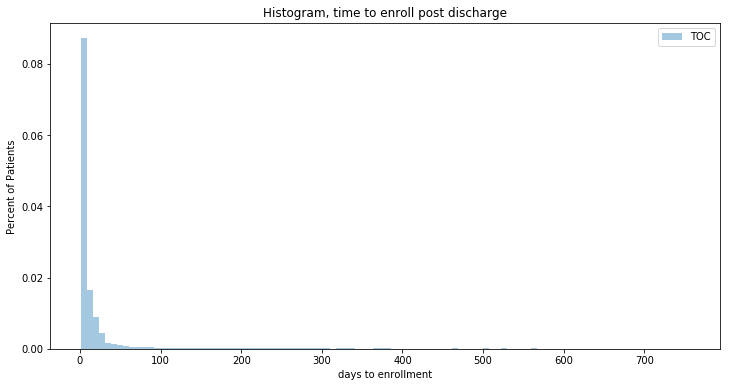

In [247]:
## Gut check - distribution of time to enroll should follow a skinny exponential distribution
## Most enrolls should happen in the first few days, then quickly tapers to long tail

fighist = plt.figure(figsize=(12,6))
ax1 = fighist.add_subplot(111)
ax1.set_title('Histogram, time to enroll post discharge')
ax1.hist(np.array(progs[progs['PRGM_NM']=='Transitions of Care - Post Discharge']['time_to_enroll'].dropna()), bins = 100, alpha = 0.4, density=1, label='TOC')
#ax1.hist(np.array(progs[progs['PRGM_NM']=='DM - CLD']['time_to_enroll'].dropna()), bins = 40, alpha = 0.6, density=1, label='CLD')
#ax1.hist(np.array(progs[progs['PRGM_NM']=='DM - HF']['time_to_enroll'].dropna()), bins = 40, alpha = 0.6, density=1, label='HF')
ax1.set_ylabel('Percent of Patients')
ax1.set_xlabel('days to enrollment')
ax1.legend();

## TOC - Feature Engineering

In [248]:
## Subset programs list to only include active members and enrollments associated with a discharge.
## Also removes patients without a lace score OR whose program was "auto-closed" as a data clean up measure.
progs_toc_w_lace = progs[(progs['PRGM_NM']=='Transitions of Care - Post Discharge') &
                  ((progs['prog_create_date']-timedelta(days=30))>progs['Eff_Date']) &
                  ((progs['prog_create_date']-timedelta(days=30))<progs['End_Date']) &
                  ((progs['time_to_enroll']<30)) &
                  (progs['PRGM_STOP_RSN']!='Auto-Closed')  &
                  (progs['lace_score'].isna()==False) &  
                  (progs['prog_create_date']<(datetime.today()-timedelta(days=35)))
                 ].reset_index()

In [249]:
## Identify assessments that occured during TOC window that interfere with the opt-out effect.
assess_that_muddy = assess[(assess['ASES_NM']=='MCG DMG Complex Assessment') |
      (assess['ASES_NM']=='IDT Care Team Note') |
      (assess['ASES_NM'] == 'Social Work Initial') |
      (assess['ASES_NM'] == 'MCG - DMG - Preventative Assessment') |
      (assess['ASES_NM'] == 'Social Work Outreach Encounter') |
      (assess['ASES_NM'] == 'MCG - DMG - High-Risk Pregnancy - Assessment') | 
      (assess['ASES_NM'] == 'IVR Survey') |
      (assess['ASES_NM'] == 'MCG - DMG - Heart Failure') |
      (assess['ASES_NM'] == 'MCG - DMG - CLD')].drop_duplicates(subset='PTNT_ASES_DK')

In [250]:
## Count the number of interfering assessments that occur during a TOC program
assess_toc_cnt = find_assessments_during_TOC(progs_toc_w_lace, assess_that_muddy)
progs_toc_w_lace['assess_dur_TOC_cnt'] = assess_toc_cnt

In [251]:
## create count and y/n columns for assessment that interfere
cm_toc_ases = find_assessments_during_program(progs_toc_w_lace, assess_toc)
cm_toc_ases_flag = list_of_counts_to_flag(cm_toc_ases)
progs_toc_w_lace['cnt_toc_cm_touch'] = cm_toc_ases
progs_toc_w_lace['toc_cm_touch_yn'] = cm_toc_ases_flag

In [252]:
## Subset to only include patients that had no interfering assessments during their 30-day TOC window
toc_interfere_ind = adms_to_one_zero(progs_toc_w_lace, 'assess_dur_TOC_cnt')
progs_toc_w_lace['toc_interfere_ind'] = toc_interfere_ind

In [253]:
progs_toc_w_lace = progs_toc_w_lace[progs_toc_w_lace['toc_interfere_ind']==0].reset_index(drop=True)

In [254]:
## Counts readmission in 30-day TOC window
thirty_day_after_TOC = get_adm_after_index_discharge(progs_toc_w_lace, admits)
progs_toc_w_lace['adm_30_after_TOC'] = thirty_day_after_TOC

In [255]:
## Converts counts of admission to binary flag
adm_yn = adms_to_one_zero(progs_toc_w_lace, 'adm_30_after_TOC')
progs_toc_w_lace['is_30_TOC_adm'] = adm_yn

In [256]:
## Drop unneeded columns
admits_cols_drop = ['level_0', 'index', 'Eff_Date', 'End_Date', 'ASGN_USR', 'lace_date_prior_enroll',
       'adm_30_after', 'los_30_after', 'los_90_after','los_90_before', 'toc_first_ases_dt'
                   ,'medrec_first_ases_dt']
progs_toc_w_lace = progs_toc_w_lace.drop(admits_cols_drop, axis=1)

In [257]:
# Give the filename you wish to save the file to
toc_regression_filename = '../data/progs_toc_20190313.csv'

# Use this function to search for any files which match your filename
files_present = os.path.isfile(toc_regression_filename)

In [258]:
# if no matching files, write to csv, if there are matching files, print statement
if not files_present:
    progs_toc_w_lace.to_csv(toc_regression_filename)
else:
    print('WARNING: This file already exists!')

In [259]:
## Create binary dummy columns for each value in categorical variables
progs_toc_ent = pd.get_dummies(pd.Series(list(progs_toc_w_lace['ENT_TYPE'])))
progs_toc_lob = pd.get_dummies(pd.Series(list(progs_toc_w_lace['LOB_SUB_CGY'])))
progs_toc_rgn = pd.get_dummies(pd.Series(list(progs_toc_w_lace['RGON_NM'])))

In [260]:
## Merges dummy columns into dataframe
progs_toc_w_lace = pd.concat([progs_toc_w_lace, progs_toc_lob, progs_toc_ent, progs_toc_rgn], axis=1)

## TOC - Data Exploration

In [261]:
## Convenience code to explore correlation between one variable and all other variables
progs_toc_w_lace.corr()['prog_duration']

EMPI                  -0.063049
age                    0.080883
is_male               -0.003630
lace_score            -0.044125
lace_to_enroll_days   -0.009078
adm_90_after          -0.040641
adm_90_before         -0.018005
time_to_enroll         0.011185
prog_duration          1.000000
index_to_first_ases    0.042806
index_to_medrec        0.055689
medrec_yn              0.007345
assess_dur_TOC_cnt          NaN
cnt_toc_cm_touch      -0.060249
toc_cm_touch_yn       -0.087860
toc_interfere_ind           NaN
adm_30_after_TOC      -0.061066
is_30_TOC_adm         -0.063132
COMMERCIAL             0.020097
MEDI-CAL              -0.160846
SENIOR                 0.107627
SENIOR ACO            -0.009561
GROUP                  0.046359
IPA                   -0.045136
LA/DOWNTOWN            0.087338
LONG BEACH             0.020491
MAGAN                  0.029784
ORANGE COUNTY         -0.223091
SAN FERNANDO VALLEY    0.023339
SAN GABRIEL VALLEY     0.040857
SOUTH BAY              0.070218
VILLAGE 

In [262]:
## Convenience code to pivot readmission flag and opt-in / opt-out flag
progs_toc_w_lace.pivot_table(values='is_30_TOC_adm', columns='toc_cm_touch_yn', aggfunc=['mean', 'count'])

mean           count      
toc_cm_touch_yn         0         1     0     1
is_30_TOC_adm    0.159187  0.121864  5415  3069

In [263]:
## Convenience code to pivot readmission flag and another variable
progs_toc_w_lace.pivot_table(values='is_30_TOC_adm', columns='is_male', aggfunc='mean')

is_male,0.0,1.0
is_30_TOC_adm,0.133364,0.158373


## TOC - Regression

In [264]:
## In earlier versions classes were more imbalanced. We accounted for this by assigning more importance
## to the minority class. In later version, we kept each class's importance = 1.
class_weight={0: 1, 1: 1}

In [265]:
## Selects explanatory variables for regression
x_cols = ['toc_cm_touch_yn', 'time_to_enroll', 'lace_score', 'prog_duration', 'IPA', 'MEDI-CAL', 'COMMERCIAL', 'is_male']

In [266]:
## Subsets columns to relevant columns 
X = np.array(progs_toc_w_lace[x_cols])

In [267]:
# ## Convenience Code to impute values for nulls in each column. 
# imput = Imputer(strategy='most_frequent')
# X = imput.fit_transform(X)

In [268]:
## Creates array for "Y" - our target variable.
y_ad_yn = np.array(progs_toc_w_lace['is_30_TOC_adm'])

In [269]:
## This code can split the dataset into training and test sets.
## In practice, we assign the entire dataset to training because we haven't used the model to predict
## This increases our n and helps find a signal for program effectiveness
X_ad_train, X_ad_test, y_ad_yn_train, y_ad_yn_test = train_test_split(X, y_ad_yn, test_size=.1)

In [270]:
## Creates a logistic regression instance. C=100000000 reduces regularization to 0.
model_ad = linear_model.LogisticRegression(C=100000000, class_weight=class_weight)

In [271]:
## Fits model instance using our X and Y matricies
model_ad.fit(X_ad_train, y_ad_yn_train)

LogisticRegression(C=100000000, class_weight={0: 1, 1: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## TOC - Explore Regression Results

In [272]:
## Having fit the model, we can now extract coefficients for X variables.
model_ad.coef_

array([[-0.29619977, -0.03302853,  0.13648927, -0.0060526 ,  0.14872792,
         0.27072063, -0.01081508,  0.08489642]])

In [273]:
## Having fit the model, we can now extract the y intercept
model_ad.intercept_

array([-2.9625177])

In [274]:
## Bootstrap likely distributions of values that each coefficient takes
ad_yn_bootstraps = bootstrap_ci_coefficients(X, y_ad_yn, 500)
ad_yn_bootstraps = pd.DataFrame(ad_yn_bootstraps, columns=x_cols)

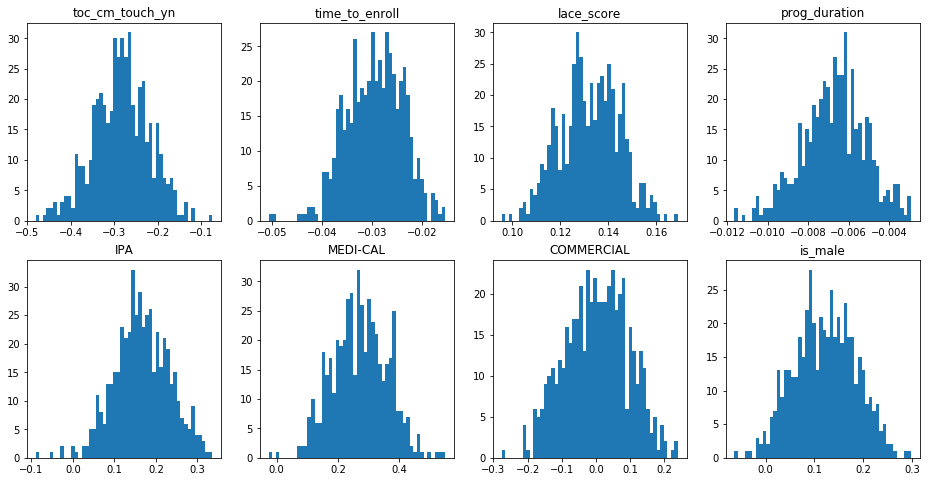

In [275]:
## Plots distributions of likely values for each X variable
fig, axes = plt.subplots(2,4, figsize=(16,8))
col_names = x_cols

for m, ax in zip(col_names, axes.flatten()):
    ax.hist(ad_yn_bootstraps[m], bins=50)
    ax.set_title(m)

In [276]:
## Calculate Model Accuracy
r2 = model_ad.score(X, y_ad_yn)
r2

0.8543140028288543

In [277]:
## Generate prediction probabilities and evaluate 
## predictiveness of model with AUC.
y_ad_yn_preds = model_ad.predict_proba(X_ad_test)[:,1]

In [278]:
ad_TPR, ad_FPR, ad_thresholds = roc_curve(y_ad_yn_test, y_ad_yn_preds, pos_label=None, sample_weight=None, drop_intermediate=True)

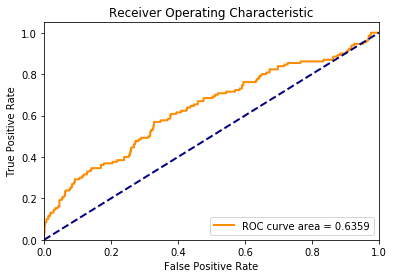

In [279]:
## Plot AUC, which helps determine the predictive value of the model
plotroc(ad_TPR, ad_FPR)

# CHF - Data Cleaning

In [280]:
## Create an "image" of all programs data set, specifically for CHF.
progs_chf = progs

In [281]:
## Subset all programs to relevant CHF programs.
progs_chf = progs_chf[(progs_chf['PRGM_NM']=='DM - HF') & 
                    ((progs_chf['prog_create_date']-timedelta(days=90))>progs_chf['Eff_Date']) &
                    ((progs_chf['prog_create_date']-timedelta(days=90))<progs_chf['End_Date']) &
                      (progs_chf['PRGM_STOP_RSN']!='Auto-Closed')  &
                      (progs_chf['prog_create_date']<(datetime.today()-timedelta(days=90)))].reset_index(drop=True)

In [282]:
## Identify Assessments that occured during CHF window that interfere with the opt-out population.
assess_that_muddy_chf = assess[(assess['ASES_NM']=='MCG DMG Complex Assessment') |
      (assess['ASES_NM']=='IDT Care Team Note') |
      (assess['ASES_NM'] == 'Social Work Initial') |
      (assess['ASES_NM'] == 'MCG - DMG - Preventative Assessment') |
      (assess['ASES_NM'] == 'Social Work Outreach Encounter') |
      (assess['ASES_NM'] == 'MCG - DMG - High-Risk Pregnancy - Assessment') | 
      (assess['ASES_NM'] == 'IVR Survey') |
      (assess['ASES_NM'] == 'MCG - DMG - CLD') |
      (assess['ASES_NM']=='MCG - Post-Hospitalization Follow-Up') | 
      (assess['ASES_NM']=='Post-Hospitalization Follow-up') |
      (assess['ASES_NM']=='TOC Post Discharge Outreach') |
      (assess['ASES_NM']=='CM Medication Reconciliation') |
      (assess['ASES_NM']=='Med Reconciliation')].drop_duplicates(subset='PTNT_ASES_DK')

In [283]:
## create assessments table for CHF
assess_chf_mhfk = assess[assess['ASES_NM']=='MCG - Heart Failure - Knowledge of Condition and Treatment Plan']
assess_chf_mdhf = assess[assess['ASES_NM']=='MCG - DMG - Heart Failure']
assess_chf_mdhfk = assess[assess['ASES_NM']=='MCG - DMG - Heart Failure - Knowledge of Condition and Treatment Plan']
frames = [assess_chf_mhfk, assess_chf_mdhf, assess_chf_mdhfk]
assess_chf = pd.concat(frames)

In [284]:
## Count interfering assessments during program
assess_chf_cnt = find_assessments_during_program_dm(progs_chf, assess_that_muddy_chf)
progs_chf['assess_dur_chf_cnt'] = assess_chf_cnt

In [285]:
## cnt chf related assessments during programs
cnt_chf_90 = find_assessments_during_program_dm(progs_chf, assess_chf)

In [286]:
## Converts counts to flag indicating whether a patient opted in or out of the CHF program
progs_chf['chf_ases'] = cnt_chf_90
cm_chf_ases_yn = list_of_counts_to_flag(cnt_chf_90)
progs_chf['chf_ases_yn'] = cm_chf_ases_yn

In [287]:
## Creates flag if program has an interfering assessment, subsets programs to those where flag==0
chf_interfere_ind = adms_to_one_zero(progs_chf, 'assess_dur_chf_cnt')
progs_chf['chf_interfere_ind'] = chf_interfere_ind

progs_chf = progs_chf[((progs_chf['chf_interfere_ind']==0) & (progs_chf['chf_ases_yn']==0)) |
                     (progs_chf['chf_ases_yn']==1)]

In [288]:
progs_chf.reset_index(drop=True, inplace=True)

In [289]:
## Identify the date and name of first CHF assessment within a CHF program
chf_first_ases_dt, chf_first_ases_nm = find_first_assess(progs_chf, assess_chf)

progs_chf['chf_first_ases_dt'] = chf_first_ases_dt
progs_chf['chf_first_ases_nm'] = chf_first_ases_nm

In [290]:
# Give the filename you wish to save the file to
progs_chf_filename = '../data/progs_chf_20190313.csv'

# Use this function to search for any files which match your filename
files_present = os.path.isfile(progs_chf_filename)

In [291]:
# if no matching files, write to csv, if there are matching files, print statement
if not files_present:
    progs_chf.to_csv(progs_chf_filename)
else:
    print('WARNING: This file already exists!')

## CHF - Explore

In [292]:
progs_chf.pivot_table(values=['adm_90_after', 'adm_90_before'], index='chf_ases_yn', aggfunc='mean')

,adm_90_after,adm_90_before
chf_ases_yn,,
0,0.132231,0.347107
1,0.412338,0.824675


## Develop Dataset for Regression

In [293]:
progs_chf_reg = progs_chf.drop(columns = ['index', 'RGON_NM', 'LOB_SUB_CGY', 'ENT_TYPE', 'Eff_Date',
       'End_Date', 'PRGM_NM', 'PRGM_STOP_RSN', 'ASGN_USR', 'prog_create_date',
       'prog_end_date', 'age', 'is_male', 'index_date', 'lace_score',
       'lace_date_prior_enroll', 'lace_to_enroll_days', 'adm_30_after',
       'los_30_after', 'los_90_after',
       'los_90_before', 'time_to_enroll', 'prog_duration', 'toc_first_ases_dt',
       'medrec_first_ases_dt', 'index_to_first_ases', 'index_to_medrec',
       'medrec_yn', 'assess_dur_chf_cnt', 'chf_ases',
       'chf_interfere_ind', 'chf_first_ases_dt', 'chf_first_ases_nm'])

In [294]:
progs_chf_reg_2 = progs_chf_reg

In [295]:
progs_chf_reg_3 = pd.concat([progs_chf_reg, progs_chf_reg_2], axis=0).reset_index()

In [296]:
n = progs_chf_reg.shape[0]

In [297]:
progs_chf_reg_3['Admits (1 before 0 after)'] = np.concatenate([np.zeros(n),np.ones(n)],axis=0)

In [298]:
progs_chf_reg_3['Admits'] = np.where(progs_chf_reg_3['Admits (1 before 0 after)'] == 0, 
                                    progs_chf_reg_3['adm_90_after'], progs_chf_reg_3['adm_90_before'])

In [299]:
progs_chf_reg_3['Interaction'] = progs_chf_reg_3['chf_ases_yn'] * progs_chf_reg_3['Admits (1 before 0 after)']

In [300]:
# Give the filename you wish to save the file to
chf_regression_filename = '../data/chf_regression_20190313.csv'

# Use this function to search for any files which match your filename
files_present = os.path.isfile(chf_regression_filename)

In [301]:
# if no matching files, write to csv, if there are matching files, print statement
if not files_present:
    progs_chf_reg_3.to_csv(chf_regression_filename)
else:
    print('WARNING: This file already exists!')

#### Parallel Assumption Testing

In [302]:
rel_empi_chf = list(progs_chf['EMPI'].unique())
rel_admits_chf = admits[admits['EMPI'].isin(rel_empi_chf)].reset_index(drop=True)

In [303]:
chf_admit_yn, chf_optin_yn, chf_week = tag_chf_admissions(progs_chf, rel_admits_chf)

In [304]:
rel_admits_chf['chf_admit_yn'] = chf_admit_yn
rel_admits_chf['chf_optin_yn'] = chf_optin_yn
rel_admits_chf['chf_optin_week'] = chf_week

In [305]:
# Give the filename you wish to save the file to
chf_parallel_filename = '../data/chf_parallel_20190313.csv'

# Use this function to search for any files which match your filename
files_present = os.path.isfile(chf_parallel_filename)

In [306]:
# if no matching files, write to csv, if there are matching files, print statement
if not files_present:
    rel_admits_chf.pivot_table('chf_admit_yn', index='chf_optin_week', columns='chf_optin_yn', aggfunc='sum').to_csv(chf_parallel_filename)
else:
    print('WARNING: This file already exists!')

## COPD - Data Cleaning

In [307]:
progs_copd = progs

In [308]:
progs_copd = progs_copd[(progs_copd['PRGM_NM']=='DM - CLD') & 
                      ((progs_copd['prog_create_date']-timedelta(days=90))>progs_copd['Eff_Date']) &
                      ((progs_copd['prog_create_date']-timedelta(days=90))<progs_copd['End_Date']) &
                        (progs_copd['PRGM_STOP_RSN']!='Auto-Closed')  &
                        (progs_copd['prog_create_date']<(datetime.today()-timedelta(days=90)))].reset_index(drop=True)

In [309]:
## Identify Assessments that occured during COPD window that interfere with the opt-out effect.
assess_that_muddy_copd = assess[(assess['ASES_NM']=='MCG DMG Complex Assessment') |
      (assess['ASES_NM']=='IDT Care Team Note') |
      (assess['ASES_NM'] == 'Social Work Initial') |
      (assess['ASES_NM'] == 'MCG - DMG - Preventative Assessment') |
      (assess['ASES_NM'] == 'Social Work Outreach Encounter') |
      (assess['ASES_NM'] == 'MCG - DMG - High-Risk Pregnancy - Assessment') | 
      (assess['ASES_NM'] == 'IVR Survey') |
      (assess['ASES_NM'] == 'MCG - DMG - Heart Failure') |                         
      (assess['ASES_NM']=='MCG - Post-Hospitalization Follow-Up') | 
      (assess['ASES_NM']=='Post-Hospitalization Follow-up') |
      (assess['ASES_NM']=='TOC Post Discharge Outreach') |
      (assess['ASES_NM']=='CM Medication Reconciliation') |
      (assess['ASES_NM']=='Med Reconciliation')].drop_duplicates(subset='PTNT_ASES_DK')

In [310]:
## create assessments table for COPD

assess_copd_mcopdk = assess[assess['ASES_NM']=='MCG - Chronic Obstructive Pulmonary Disease - Knowledge of Condition and Treatment Plan'].drop_duplicates(subset='PTNT_ASES_DK')
assess_copd_mdchr = assess[assess['ASES_NM']=='MCG - DMG - Chronic Lung Disease (CLD)'].drop_duplicates(subset='PTNT_ASES_DK')
assess_copd_mdcld = assess[assess['ASES_NM']=='MCG - DMG - CLD'].drop_duplicates(subset='PTNT_ASES_DK')
frames = [assess_copd_mcopdk, assess_copd_mdchr, assess_copd_mdcld]
assess_copd = pd.concat(frames)

In [311]:
assess_copd_cnt = find_assessments_during_program_dm(progs_copd, assess_that_muddy_copd)
progs_copd['assess_dur_copd_cnt'] = assess_copd_cnt

In [312]:
copd_interfere_ind = adms_to_one_zero(progs_copd, 'assess_dur_copd_cnt')
progs_copd['copd_interfere_ind'] = copd_interfere_ind

progs_copd = progs_copd[(progs_copd['copd_interfere_ind']==0)]

In [313]:
progs_copd.reset_index(drop=True, inplace=True)

In [314]:
## cnt copd related assessments during programs
cnt_copd_90 = find_assessments_during_program_dm(progs_copd, assess_copd)

In [315]:
progs_copd['copd_ases'] = cnt_copd_90
cm_copd_ases_yn = list_of_counts_to_flag(cnt_copd_90)

In [316]:
progs_copd['copd_ases_yn'] = cm_copd_ases_yn

In [317]:
copd_first_ases_dt, copd_first_ases_nm = find_first_assess(progs_copd, assess_copd)

progs_copd['copd_first_ases_dt'] = copd_first_ases_dt
progs_copd['copd_first_ases_nm'] = copd_first_ases_nm

In [318]:
# Give the filename you wish to save the file to
progs_copd_filename = '../data/progs_copd_20190313.csv'

# Use this function to search for any files which match your filename
files_present = os.path.isfile(progs_copd_filename)

In [319]:
# if no matching files, write to csv, if there are matching files, print statement
if not files_present:
    progs_copd.to_csv(progs_copd_filename)
else:
    print('WARNING: This file already exists!')

## COPD - Explore

In [320]:
progs_copd.pivot_table(values=['adm_90_after', 'adm_90_before'], index='copd_ases_yn', aggfunc='mean')

,adm_90_after,adm_90_before
copd_ases_yn,,
0,0.125000,0.273438
1,0.058824,0.147059


## Develop Dataset for Regression

In [321]:
progs_copd_reg = progs_copd.drop(columns = ['index', 'RGON_NM', 'LOB_SUB_CGY', 'ENT_TYPE', 'Eff_Date',
       'End_Date', 'PRGM_NM', 'PRGM_STOP_RSN', 'ASGN_USR', 'prog_create_date',
       'prog_end_date', 'age', 'is_male', 'index_date', 'lace_score',
       'lace_date_prior_enroll', 'lace_to_enroll_days', 'adm_30_after',
       'los_30_after', 'los_90_after',
       'los_90_before', 'time_to_enroll', 'prog_duration', 'toc_first_ases_dt',
       'medrec_first_ases_dt', 'index_to_first_ases', 'index_to_medrec',
       'medrec_yn', 'assess_dur_copd_cnt', 'copd_ases',
       'copd_interfere_ind', 'copd_first_ases_dt', 'copd_first_ases_nm'])

In [322]:
progs_copd_reg_2 = progs_copd_reg

In [323]:
progs_copd_reg_3 = pd.concat([progs_copd_reg, progs_copd_reg_2], axis=0).reset_index()

In [324]:
n1 = progs_copd_reg.shape[0]

In [325]:
progs_copd_reg_3['Admits (1 before 0 after)'] = np.concatenate([np.zeros(n1),np.ones(n1)],axis=0)

In [326]:
progs_copd_reg_3['Admits'] = np.where(progs_copd_reg_3['Admits (1 before 0 after)'] == 0, 
                                    progs_copd_reg_3['adm_90_after'], progs_copd_reg_3['adm_90_before'])

In [327]:
progs_copd_reg_3['Interaction'] = progs_copd_reg_3['copd_ases_yn'] * progs_copd_reg_3['Admits (1 before 0 after)']

In [328]:
# Give the filename you wish to save the file to
copd_regression_filename = '../data/copd_regression_20190313.csv'

# Use this function to search for any files which match your filename
files_present = os.path.isfile(copd_regression_filename)

In [329]:
# if no matching files, write to csv, if there are matching files, print statement
if not files_present:
    progs_copd_reg_3.to_csv(copd_regression_filename)
else:
    print('WARNING: This file already exists!')

#### Parallel Assumption Testing

In [330]:
rel_empi = list(progs_copd['EMPI'].unique())
rel_admits = admits[admits['EMPI'].isin(rel_empi)].reset_index(drop=True)

In [331]:
copd_admit_yn, copd_optin_yn, copd_week = tag_copd_admissions(progs_copd, rel_admits)

In [332]:
rel_admits['copd_admit_yn'] = copd_admit_yn
rel_admits['copd_optin_yn'] = copd_optin_yn
rel_admits['copd_optin_week'] = copd_week

In [333]:
# Give the filename you wish to save the file to
copd_parallel_filename = '../data/copd_parallel_20190313.csv'

# Use this function to search for any files which match your filename
files_present = os.path.isfile(copd_parallel_filename)

In [334]:
# if no matching files, write to csv, if there are matching files, print statement
if not files_present:
    rel_admits.pivot_table('copd_admit_yn', index='copd_optin_week', columns='copd_optin_yn', aggfunc='sum').to_csv(copd_parallel_filename)
else:
    print('WARNING: This file already exists!')